<a href="https://colab.research.google.com/github/JayNguyen-123/Fire-Detection-using-CNN/blob/main/FireDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

sns.set_style('darkgrid')



In [ ]:
df= pd.DataFrame(columns=['path', 'label'])

def add_image_to_df(directory, label):
  for dirname, _, filenames in os.walk(directory):
    for filename in filenames:
      df.loc[len(df)] = [os.path.join(dirname, filename), label]

# add fire images
add_image_to_df('/content/sample_data/fires_images', 'fire') # fire images

add_image_to_df('/content/sample_data/Non_fires_images', 'non_fire') # non_fire image

df = df.sample(frac=1).reset_index(drop=True)


In [ ]:

# Create the scatter plot
fig = px.scatter(
    data_frame=df,
    x=df.index,
    y='label',
    color='label',
    title='Distribution of Fire and Non-Fire Images'
)

# Update marker size
fig.update_traces(marker_size=2)

fig.add_trace(go.Pie(values=df['label'].value_counts().to_numpy(), labels=df['label'].value_counts().index, marker=dict(colors=['lightblue','pink'])), row=1, col=2)




Exception: The (row, col) pair sent is out of range. Use Figure.print_grid to view the subplot grid. 

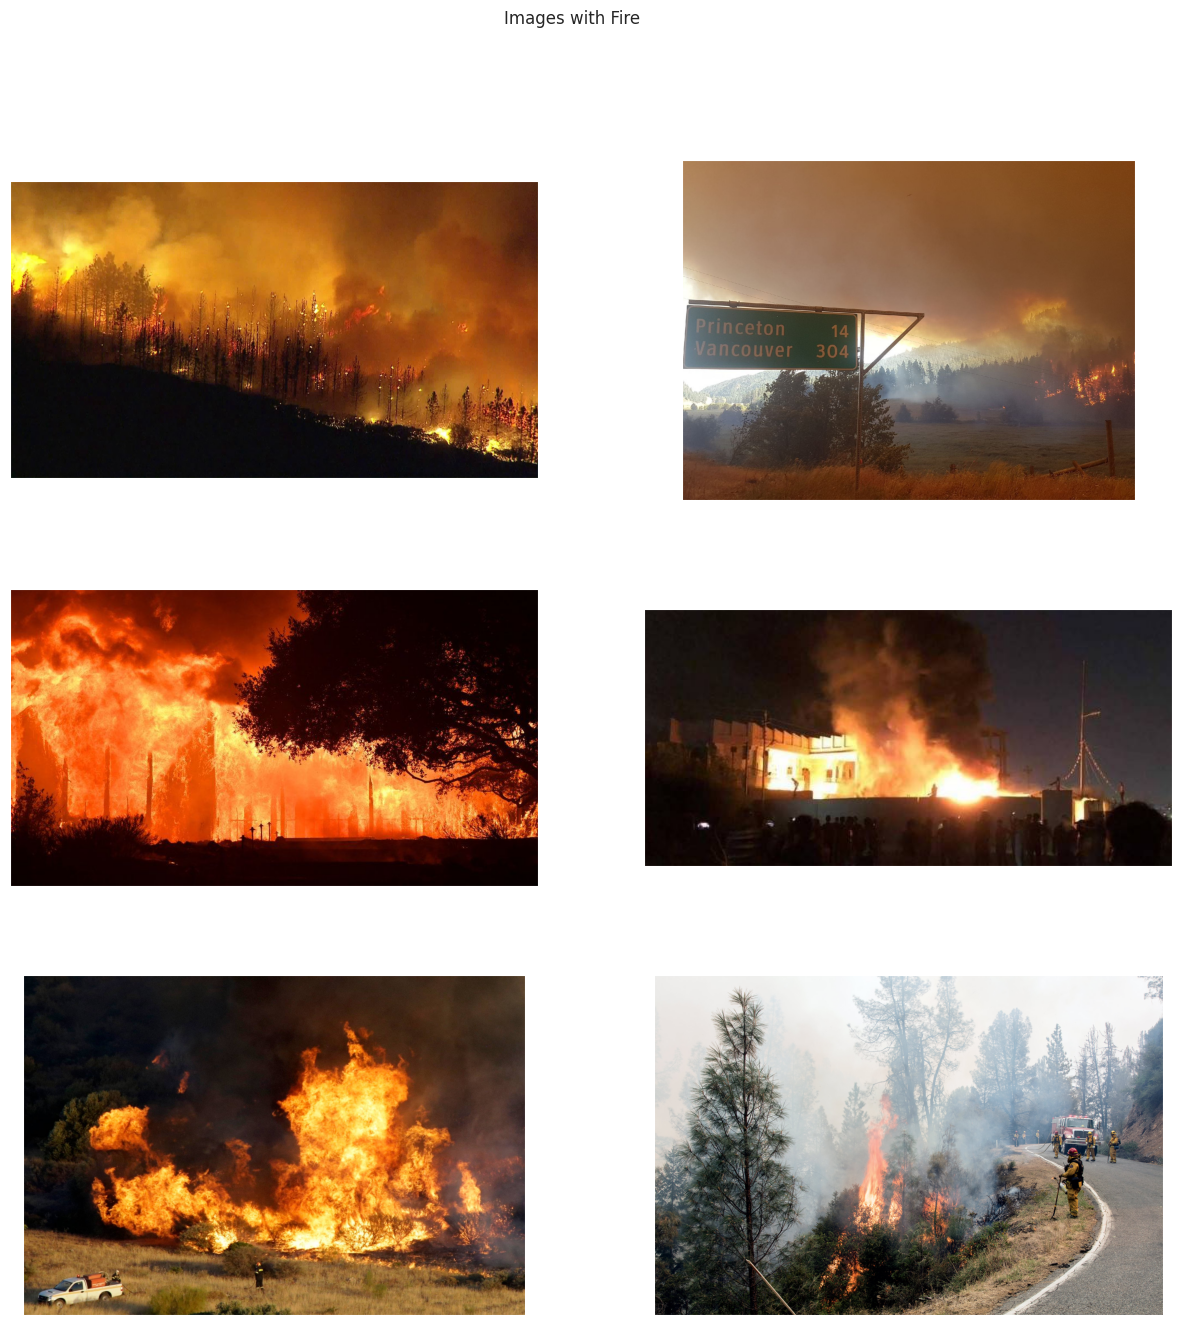

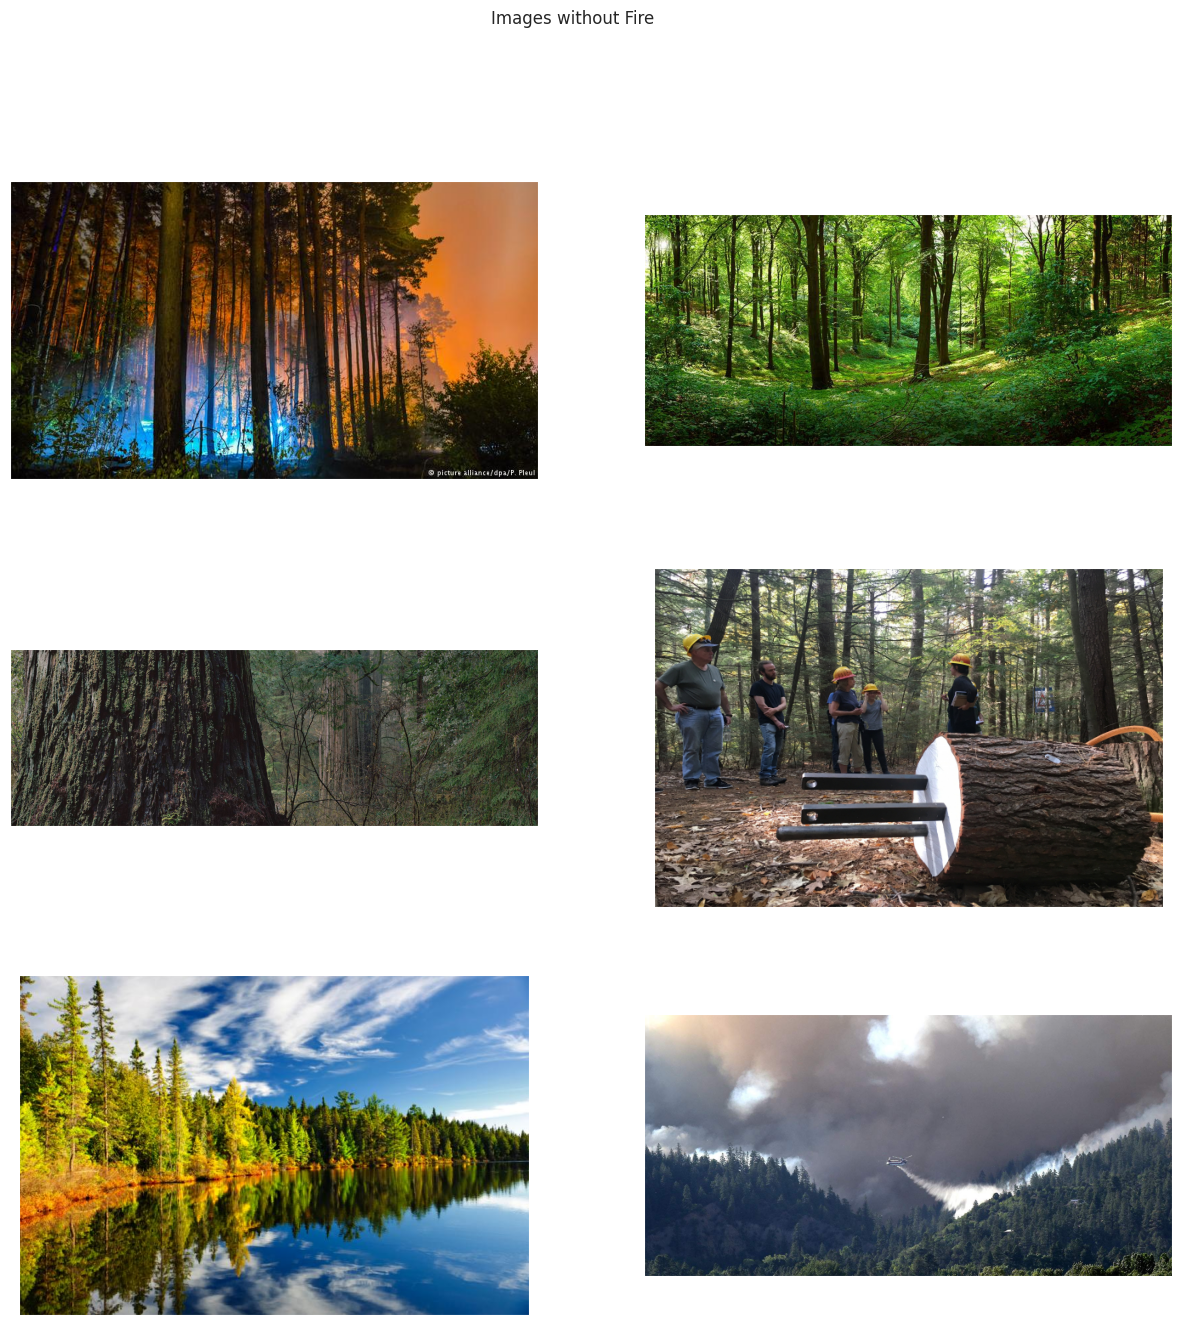

In [ ]:
def visualize_images(label, title):
    data = df[df['label'] == label]
    pics = 6  # Set the number of pics
    fig, ax = plt.subplots(int(pics // 2), 2, figsize=(15, 15))
    plt.suptitle(title)
    ax = ax.ravel()
    for i in range((pics // 2) * 2):
        path = data.sample(1).loc[:, 'path'].to_numpy()[0]
        img = image.load_img(path)
        img = image.img_to_array(img) / 255
        ax[i].imshow(img)
        ax[i].axes.xaxis.set_visible(False)
        ax[i].axes.yaxis.set_visible(False)
visualize_images('fire', 'Images with Fire')
visualize_images('non_fire', 'Images without Fire')


In [ ]:


generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=2,
    zoom_range=0.2,
    rescale=1/255,
    validation_split=0.2
)
train_gen = generator.flow_from_dataframe(df, x_col='path',
                                          y_col='label',
                                          images_size=(256,256),
                                          class_mode='binary',
                                          subset='training')
val_gen = generator.flow_from_dataframe(df, x_col='path',
                                        y_col='label',
                                        image_size=(256,256),
                                        class_mode='binary',
                                        subset='validation'
                                        )

class_indices = {}
for key in train_gen.class_indices.keys():
  class_indices[train_gen.class_indices[key]] = key

print(class_indices)


Found 800 validated image filenames belonging to 2 classes.
Found 199 validated image filenames belonging to 2 classes.
{0: 'fire', 1: 'non_fire'}


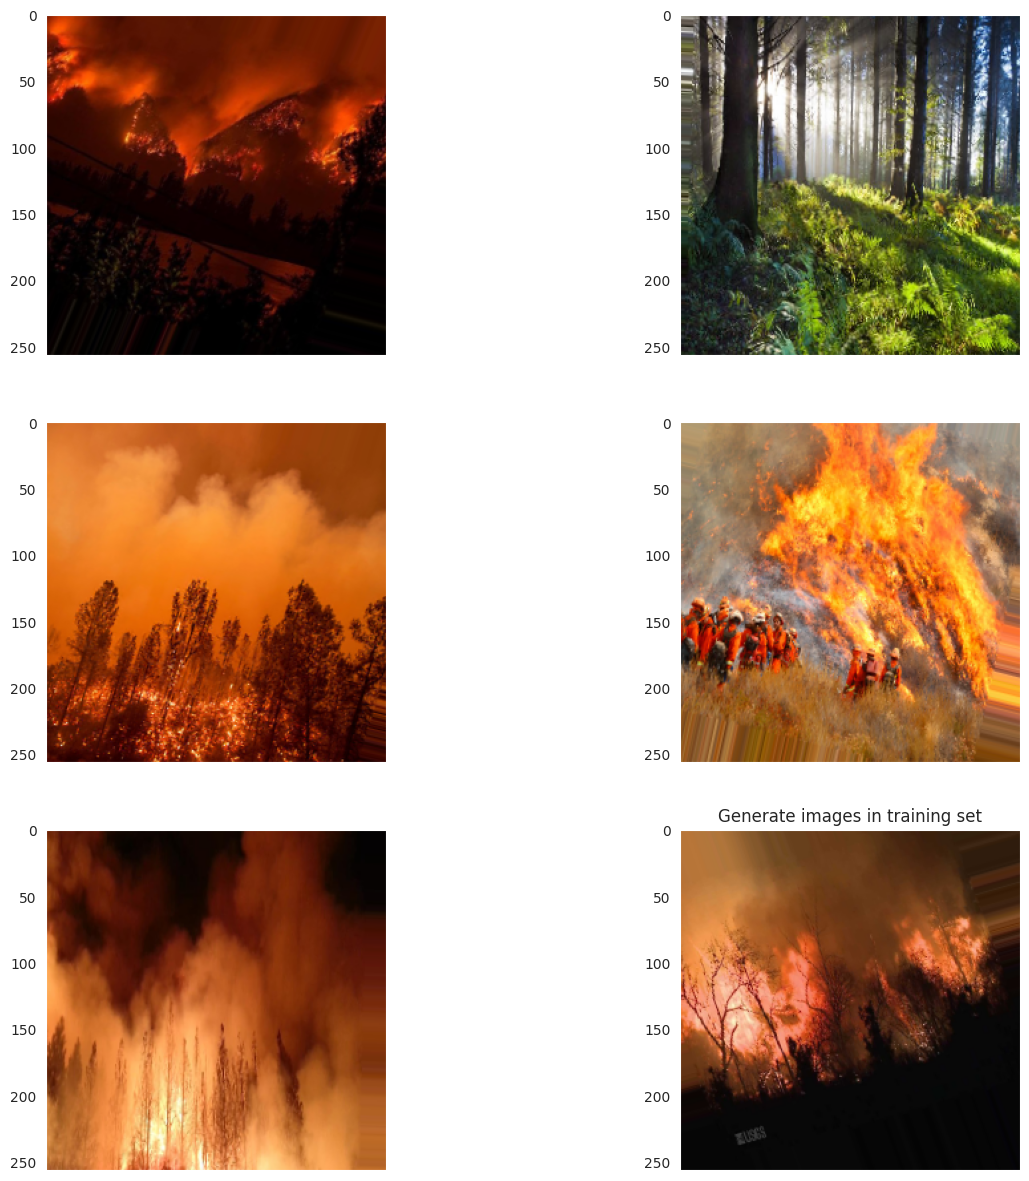

In [ ]:
# visualize augmented images

sns.set_style('dark')
pics = 6
fig, ax = plt.subplots(int(pics//2), 2, figsize=(15,15))
plt.title("Generate images in training set")
ax = ax.ravel()
for i in range((pics//2) * 2):
  ax[i].imshow(train_gen[0][0][i])
  ax[i].axes.xaxis.set_visible(False)
  ax[i].axes.xaxis.set_visible(False)




In [ ]:
from warnings import filters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(2,2), activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64, kernel_size=(2,2), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=128, kernel_size=(2,2), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()




/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 255, 255, 32)        │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 126, 126, 64)        │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 123008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       7,872,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,916,257 (30.20 MB)

 Trainable params: 7,916,257 (30.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.metrics import Recall, AUC
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Recall(), AUC()])

# defining callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)




In [ ]:
model.fit(x=train_gen, batch_size=32, epochs=15, validation_data=val_gen, callbacks=[early_stopping, reduce_lr_on_plateau])


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



25/25 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.7080 - auc: 0.5507 - loss: 0.7254 - recall: 0.0837 - val_accuracy: 0.9347 - val_auc: 0.9796 - val_loss: 0.2699 - val_recall: 0.7593 - learning_rate: 0.0010
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 115s 4s/step - accuracy: 0.9415 - auc: 0.9825 - loss: 0.2021 - recall: 0.8520 - val_accuracy: 0.8342 - val_auc: 0.9646 - val_loss: 0.3819 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.9058 - auc: 0.9738 - loss: 0.1957 - recall: 0.8480 - val_accuracy: 0.9447 - val_auc: 0.9890 - val_loss: 0.1332 - val_recall: 0.9074 - learning_rate: 0.0010
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.9574 - auc: 0.9925 - loss: 0.1010 - recall: 0.8763 - val_accuracy: 0.9196 - val_auc: 0.9822 - val_loss: 0.2057 - val_recall: 0.7037 - learning_rate: 0.0010
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.9591 - auc: 0.9882 - loss: 0.1243 - recall: 0.8827 - val_accur

In [ ]:
# evaluating model
eval_list = model.evaluate(val_gen, return_dict=True)
for metric in eval_list.keys():
  print(metric+ f": {eval_list[metric]:.2f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9457 - auc: 0.9879 - loss: 0.1214 - recall: 0.9054
accuracy: 0.94
auc: 0.99
loss: 0.12
recall: 0.89


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50241  100 50241    0     0   140k      0 --:--:-- --:--:-- --:--:--  140k


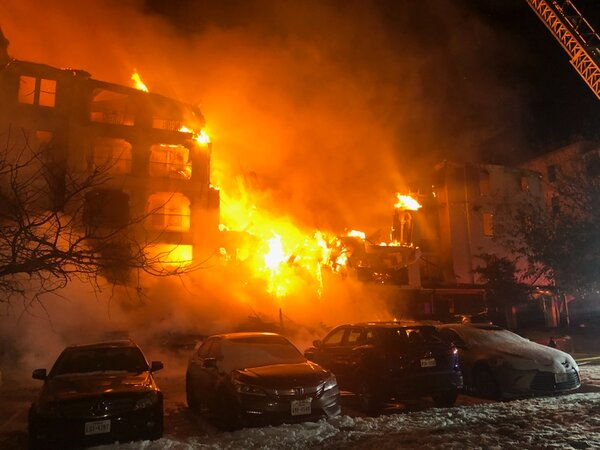

In [ ]:
# making a prediction

!curl https://static01.nyt.com/images/2021/02/19/world/19storm-briefing-texas-fire/19storm-briefing-texas-fire-articleLarge.jpg --output predict.jpg
#loading the image
img = image.load_img('predict.jpg')
img



In [ ]:
# Downloading the image
!curl https://static01.nyt.com/images/2021/02/19/world/19storm-briefing-texas-fire/19storm-briefing-texas-fire-articleLarge.jpg --output predict.jpg
#loading the image
img = image.load_img('predict.jpg')
img

img = image.img_to_array(img)/255
img = tf.image.resize(img,(256,256))
img = tf.expand_dims(img,axis=0)

#print("Image Shape",img.shape)

prediction = int(tf.round(model.predict(x=img)).numpy()[0][0])
print("The predicted value is: ",prediction,"and the predicted label is:",class_indices[prediction])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 50241  100 50241    0     0   116k      0 --:--:-- --:--:-- --:--:--  116k
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
The predicted value is:  0 and the predicted label is: fire
